<a href="https://colab.research.google.com/github/neelkanthrawat/QBM_sept2022/blob/main/qbm_codes/mcmc_cl_and_quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter

In [2]:
# !pip install qiskit ipywidgets # while working on google colab!

In [3]:
# while working on google colab, run this cell
# !wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils_2.py

In [4]:
from qbm_utils_2 import *

### Define the model

In [25]:
# define the model
np.random.seed(1)# should always be in the same cell!  
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.    -0.145 -0.35  -0.085  0.09  -1.245  0.93   0.04 ]
 [-0.145  0.     0.29  -1.37  -0.585 -0.635  0.875 -0.085]
 [-0.35   0.29   0.     0.23  -0.885  0.195  0.6    0.395]
 [-0.085 -1.37   0.23   0.    -0.14   1.11  -0.52   0.245]
 [ 0.09  -0.585 -0.885 -0.14   0.     0.14   0.26  -0.005]
 [-1.245 -0.635  0.195  1.11   0.14   0.    -0.08   1.675]
 [ 0.93   0.875  0.6   -0.52   0.26  -0.08   0.     0.55 ]
 [ 0.04  -0.085  0.395  0.245 -0.005  1.675  0.55   0.   ]]
h is: [ 0.49 -0.08  1.13  1.52  2.19 -1.4  -1.44 -0.5 ]
alpha:  0.5640831659646375


### Get the true distribution

In [26]:
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in states_nbit ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn=value_sorted_dict( dict(zip(states_nbit, prob_vals )), reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    #plot_histogram([boltz_prob_distn], legend=["analytical"], sort="value_desc")
    plot_bargraph_desc_order(boltz_prob_distn, label="analytical",plot_first_few=20); plt.legend()
    return boltz_prob_distn

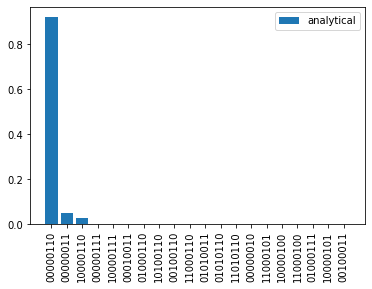

In [27]:
states_nbit=states(num_spins=n_spins)
temp=0.35
boltz_prob_distn=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)

In [28]:
mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
print("actual_avg_mag: ",actual_avg_mag)

actual_avg_mag:  -3.9452232402199825


### Function to run different number of chains of mcmc for a particular problem instance

In [29]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc:{is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=cl_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=cl_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, cl_mcmc_after_trsn, cl_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [51]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=10000;num_seperate_mcmc_chains=5; return_last_n_states=N_hops
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

Whether running quantum mcmc:False


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

starting with:  10011000



 20%|████████████████▊                                                                   | 1/5 [00:00<00:01,  2.13it/s]

starting with:  00001011



 40%|█████████████████████████████████▌                                                  | 2/5 [00:00<00:01,  2.09it/s]

starting with:  11000101



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:01<00:00,  2.14it/s]

starting with:  11010011



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:01<00:00,  2.11it/s]

starting with:  00101000



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


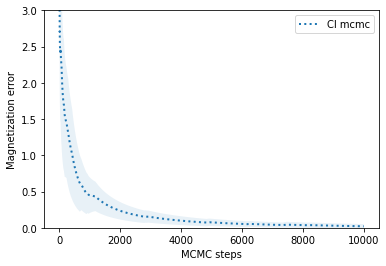

In [52]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops# 

list_for_df_running_avg_seperate_mcmc = []
for m in range(0, num_seperate_mcmc_chains):
    list_for_df_running_avg_seperate_mcmc.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc[m][:first_few+1]))

mean_magnetization = np.mean(list_for_df_running_avg_seperate_mcmc, axis=0) - actual_avg_mag
std_magnetization = np.std(list_for_df_running_avg_seperate_mcmc, axis=0)
plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)

plt.plot(mean_magnetization,":" ,label="Cl mcmc", linewidth=2)

# plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()
plt.ylim(0, 3)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.show()


In [37]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))*(1./return_last_n_states))
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn


## KL DIVERGENCE
def kl_divergence(dict_prob_distn_data,dict_prob_distn_model):
    ''' Borrowed from an old notebook''' 
    list_prob_model=list(dict_prob_distn_data.values())
    list_prob_data=list(dict_prob_distn_model.values())
    
    to_return=0
    for i in range(0,len(list_prob_model)):
        if(list_prob_data[i]== 0):
            to_return+= 0
        if(list_prob_model[i]!= 0):
            to_return+=list_prob_data[i]*np.log(list_prob_model[i]/list_prob_data[i])
    to_return=(-1)*to_return
    
    return to_return

<Figure size 432x288 with 0 Axes>

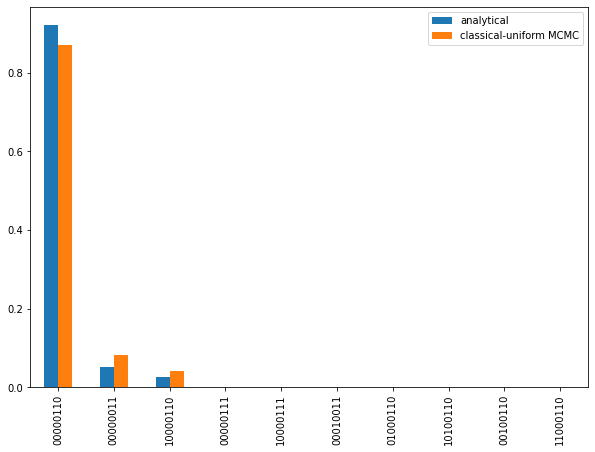

In [38]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=get_empirical_distn(dict_mean_occurences)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [39]:
kl_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn)

0.03193417254339974

### Quantum enhanced MCMC

In [40]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops_q=500;num_seperate_mcmc_chains=5; return_last_n_states=N_hops
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops_q, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

Whether running quantum mcmc:True


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

starting with:  01000111



 20%|████████████████▊                                                                   | 1/5 [00:41<02:47, 41.88s/it]

starting with:  11010000



 40%|█████████████████████████████████▌                                                  | 2/5 [01:21<02:02, 40.81s/it]

starting with:  00111111



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:59<01:18, 39.22s/it]

starting with:  00001011



 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:37<00:38, 38.66s/it]

starting with:  01000010



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.39s/it]


In [53]:
# print("dict_seperate_chains_states_distn_mcmc_q")
# print(dict_seperate_chains_states_distn_mcmc_q)
# print("dict_seperate_chains_sprime_mcmc_q")
# print(dict_seperate_chains_sprime_mcmc_q)
# print("dict_seperate_chains_accepted_mcmc_q")
# print(dict_seperate_chains_accepted_mcmc_q)

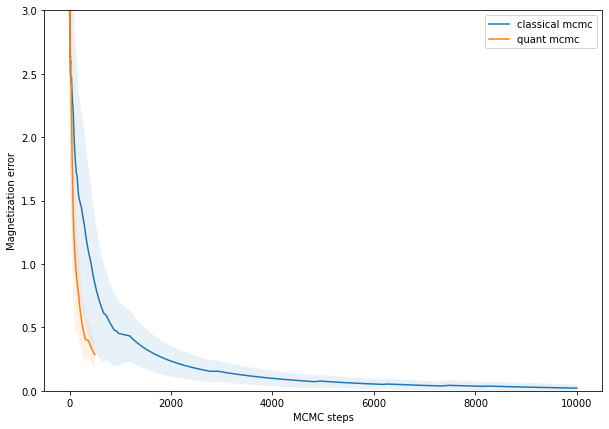

In [57]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops_q# 
list_for_df_running_avg_seperate_mcmc_q = []
for m in range(0, num_seperate_mcmc_chains):
    list_for_df_running_avg_seperate_mcmc_q.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]))

mean_magnetization_q = np.mean(list_for_df_running_avg_seperate_mcmc_q, axis=0) - actual_avg_mag
std_magnetization_q = np.std(list_for_df_running_avg_seperate_mcmc_q, axis=0)

plt.figure(figsize=(10,7))

plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)
plt.fill_between(range(len(mean_magnetization_q)), mean_magnetization_q+std_magnetization_q/2, mean_magnetization_q-std_magnetization_q/2, alpha=0.1)

# magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
# actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)

plt.plot(mean_magnetization,"-" ,label="classical mcmc")
plt.plot(mean_magnetization_q,"-" ,label="quant mcmc")
# plt.axhline(y=actual_avg_mag,linestyle="-", color="k" ,label="Actual")
plt.legend()
plt.ylim(0, 3)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.show()

<Figure size 432x288 with 0 Axes>

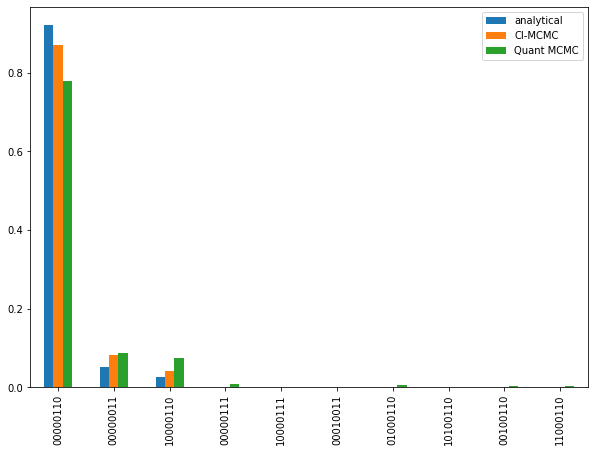

In [48]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_prob_distn_q=get_empirical_distn(dict_mean_occurences_q)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [49]:
print("KL divergence quantum case:");
print(kl_divergence(dict_empirical_prob_distn_q,boltz_prob_distn))
print("KL divergence classical case:")
print(kl_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn))

KL divergence quantum case:
0.159061631702994
KL divergence classical case:
0.03193417254339974
